In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

c:\Projects\SureelAIAssignment\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change batch size according to your memory
batch_size = 128

In [3]:
# prompts for CIFAR-10 from https://github.com/openai/CLIP/blob/main/data/prompts.md
templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]

# function to unpickle the CIFAR-10 metadata
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='utf-8')
    return dict

In [4]:
# loading the CIFAR-10 dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
metadata = unpickle('./data/cifar-10-batches-py/batches.meta')
label_names = metadata['label_names']

Files already downloaded and verified


In [5]:
# loading the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
model = model.to(device)
model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [6]:
# calculation and aggregation of text embeddings from https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
class_features = []
for label in label_names:
    texts = [template.format(label) for template in templates]
    text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.mean(dim=0)
    text_features /= text_features.norm()
    class_features.append(text_features)
class_features = torch.stack(class_features).to(device)

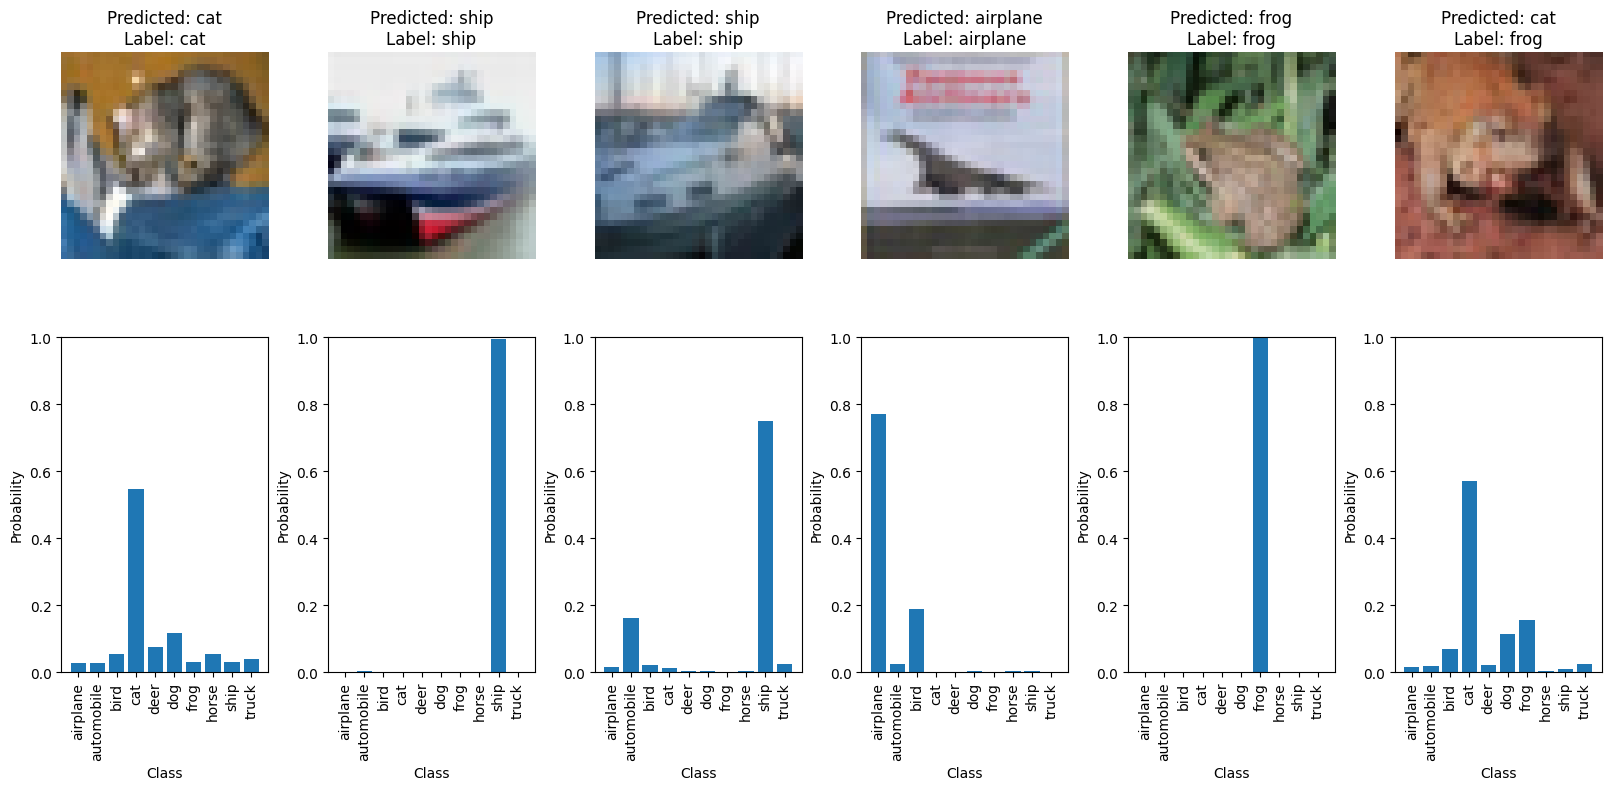

In [7]:
# plotting class probabilities of the first 6 images from CIFAR-10
fig, ax = plt.subplots(2, 6, figsize=(16, 8), constrained_layout=True)
for i in range(6):
    image, label = test_dataset[i]
    image_input = processor(images=image, return_tensors="pt", padding=True, do_rescale=False).to(device)
    with torch.no_grad():
        image_feature = model.get_image_features(**image_input)
    image_feature = image_feature / image_feature.norm(dim=-1, keepdim=True)
    logit_scale = model.logit_scale.exp()
    logits_per_text = torch.matmul(class_features, image_feature.t()) * logit_scale
    logits_per_image = logits_per_text.T
    logits_per_image = logits_per_image.cpu()
    probs = logits_per_image.softmax(dim=1)
    predicted_label = probs.argmax(dim=1).item()
    ax[0, i % 6].imshow(image.permute(1, 2, 0))
    ax[0, i % 6].set_title(f"Predicted: {label_names[predicted_label]}\nLabel: {label_names[label]}")
    ax[0, i % 6].axis("off")
    ax[1, i % 6].bar(label_names, probs.squeeze().tolist())
    ax[1, i % 6].tick_params('x', labelrotation=90)
    ax[1, i % 6].set_xlabel("Class")
    ax[1, i % 6].set_ylabel("Probability")
    ax[1, i % 6].set_ylim([0, 1])
plt.show()

In [8]:
# evaluating the model
num_correct = 0
for images, labels in tqdm(test_dataloader):
    
    image_inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

    with torch.no_grad():
        image_features = model.get_image_features(**image_inputs)

    # normalized image features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # the calculation of logits is taken from source code of CLIPModel
    # implementing this seperately allows to calculate the class embeddings only once before the loop
    # https://github.com/huggingface/transformers/blob/v4.38.2/src/transformers/models/clip/modeling_clip.py
    logit_scale = model.logit_scale.exp()
    logits_per_text = torch.matmul(class_features, image_features.t()) * logit_scale
    logits_per_image = logits_per_text.T
    logits_per_image = logits_per_image.cpu()
    probs = logits_per_image.softmax(dim=1)
    predicted_labels = probs.argmax(dim=1)
    num_correct += torch.sum(labels == predicted_labels).item()
    
acc = num_correct / len(test_dataset)
print("Accuracy:", acc)

100%|██████████| 79/79 [07:10<00:00,  5.45s/it]

Accuracy: 0.9557
